<a href="https://colab.research.google.com/github/SAMAWELJABALLI/TweetsSentimentAnalysis/blob/main/Naive_Bayes_Tunisian_Dialect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **THE NAIVE BAYES MODEL ON TUNISIAN DIALECT**

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import roc_auc_score
from bs4 import BeautifulSoup
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
import pickle
import seaborn as sns
from tqdm import tqdm
import os



In [4]:
# Load data and set labels from corpus 1 
df = pd.read_csv('/content/data_clean.csv', lineterminator='\n')
print(f'Shape of data is {df.shape}')
# Display 20 random samples
df.drop(columns=["text", "message_len"],inplace=True)
df.sample(20)


Shape of data is (152704, 6)


,Unnamed: 0,ID,label,text_clean
142236,147163,11046,1.0,chedi el hammami alexis bon attaquant un arrie...
69430,71023,21132,1.0,cooool goood
15522,15522,15522,1.0,ghawthou alina marik
23832,23832,23832,1.0,حضر التجول لازم مننو
125335,129889,20590,1.0,ربي يعينكم
83638,86384,36493,1.0,zahya
151073,156312,20195,1.0,normal kan nichriw délice lol
30244,30244,30244,1.0,اشبينا انغلوض تو نحنا عشنا باش اولادنا ترجع تق...
96928,100772,50881,1.0,السلام وعليكم السلام ورحمة الله
3720,3720,3720,1.0,bravo walid andek ekhak tkoum nakesna ken hal


# Loading saved vectors 


In [7]:
# loading bow vectors
X_train_bow = pickle.load(open("/content/drive/MyDrive/saved_feats/X_train_bow","rb"))
X_test_bow = pickle.load(open("/content/drive/MyDrive/saved_feats/X_test_bow","rb"))
bow_features = pickle.load(open("/content/drive/MyDrive/saved_feats/bow_features","rb")).tolist()
print('shape of X_train_bow is {}'.format(X_train_bow.shape))
print('shape of X_test_bow is {}'.format(X_test_bow.shape))


#loading tfidf vectors
X_train_tfidf = pickle.load(open("/content/drive/MyDrive/saved_feats/X_train_tfidf","rb"))
X_test_tfidf = pickle.load(open("/content/drive/MyDrive/saved_feats/X_test_tfidf","rb"))
tfidf_features = pickle.load(open("/content/drive/MyDrive/saved_feats/tfidf_features","rb")).tolist()
print('shape of X_train_tfidf is {}'.format(X_train_tfidf.shape))
print('shape of X_test_tfidf is {}'.format(X_test_tfidf.shape))


w2v_words = pickle.load(open("/content/drive/MyDrive/saved_feats/w2v_words","rb")).tolist()
#avgw2v
X_train_avgw2v = pickle.load(open("/content/drive/MyDrive/saved_feats/X_train_avgw2v","rb"))
X_test_avgw2v = pickle.load(open("/content/drive/MyDrive/saved_feats/X_test_avgw2v","rb"))
print('shape of X_train_avgw2v is {}'.format(X_train_avgw2v.shape))
print('shape of X_test_avgw2v is {}'.format(X_test_avgw2v.shape))

'''#tfidf-w2v
X_train_tfw2v = pickle.load(open("/content/drive/MyDrive/saved_feats/X_train_tfw2v","rb"))
X_test_tfw2v = pickle.load(open("/content/drive/MyDrive/saved_feats/X_test_tfw2v","rb"))
print('shape of X_train_tfw2v is {}'.format(X_train_tfw2v.shape))
print('shape of X_test_tfw2v is {}'.format(X_test_tfw2v.shape))

'''
y_train = np.load('/content/drive/MyDrive/saved_feats/y_train.npy',allow_pickle=True)
y_test = np.load('/content/drive/MyDrive/saved_feats/y_test.npy',allow_pickle=True)
print(f'shape of y_train is {y_train.shape}')
print(f'shape of y_test is {y_test.shape}')

shape of X_train_bow is (139367, 144497)
shape of X_test_bow is (59730, 144497)
shape of X_train_tfidf is (139367, 144497)
shape of X_test_tfidf is (59730, 144497)
shape of X_train_avgw2v is (139367, 50)
shape of X_test_avgw2v is (59730, 50)
shape of y_train is (139367,)
shape of y_test is (59730,)


# helper function to plot confusion matrix


In [8]:
# helper function to plot confusion matrix
def plot_confusion_matrixes(model,x_train,y_train,x_test,y_test):
    cm_train = confusion_matrix(y_train,model.predict(x_train))
    cm_test =  confusion_matrix(y_test,model.predict(x_test))
    class_label = ["negative", "positive"]
    df_train = pd.DataFrame(cm_train, index = class_label, columns = class_label)
    df_test = pd.DataFrame(cm_test, index = class_label, columns = class_label)
    f, axes = plt.subplots(1, 2,figsize=(12,4))

    for i in range(2):
      df = df_train if i==0 else df_test
      sns.heatmap(df, annot = True, fmt = "d",ax=axes[i])
      axes[i].set_title(f"Confusion Matrix - {'Train' if i==0 else 'Test'}")
      axes[i].set_xlabel("Predicted Label")
      axes[i].set_ylabel("True Label")
    plt.show()

# **Naive Bayes**

# **Naive Bayes On BagOfWords Features**


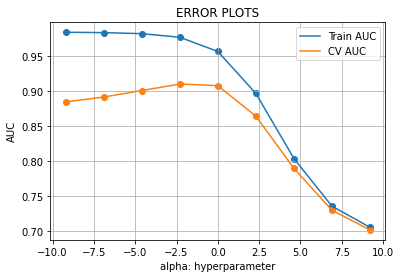

In [10]:
train_auc = []
cv_auc = []
alpha = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
for param in alpha:
    naive = MultinomialNB(alpha=param)
    naive.fit(X_train_bow,y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    y_train_pred =  naive.predict_proba(X_train_bow)[:,1]
    y_test_pred =  naive.predict_proba(X_test_bow)[:,1]
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_test, y_test_pred))
#plotting
plt.grid(True)
plt.plot(np.log(alpha), train_auc, label='Train AUC')
plt.plot(np.log(alpha), cv_auc, label='CV AUC')
plt.scatter(np.log(alpha), train_auc)
plt.scatter(np.log(alpha), cv_auc)
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

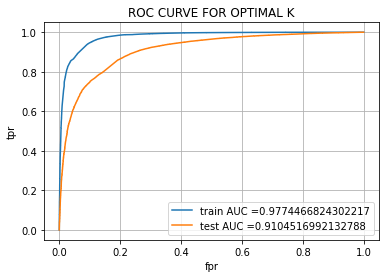

Area under train roc 0.9774466824302217
Area under test roc 0.9104516992132788


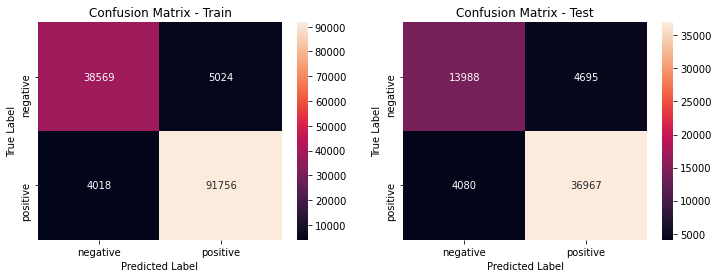


-----classification report on train data on BagOfwords Features-----

              precision    recall  f1-score   support

           0       0.91      0.88      0.90     43593
           1       0.95      0.96      0.95     95774

    accuracy                           0.94    139367
   macro avg       0.93      0.92      0.92    139367
weighted avg       0.93      0.94      0.93    139367


-----classification report on validation data on BagOfwords Features-----

              precision    recall  f1-score   support

           0       0.77      0.75      0.76     18683
           1       0.89      0.90      0.89     41047

    accuracy                           0.85     59730
   macro avg       0.83      0.82      0.83     59730
weighted avg       0.85      0.85      0.85     59730



In [34]:
from sklearn.metrics import roc_curve, auc, classification_report, accuracy_score
optimal_alpha = 0.1
naive_opt = MultinomialNB(alpha=optimal_alpha)
naive_opt = naive_opt.fit(X_train_bow,y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, naive_opt.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, naive_opt.predict_proba(X_test_bow)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr))) 
plot_confusion_matrixes(naive_opt,X_train_bow,y_train,X_test_bow,y_test)

#classification report on train data
print('\n-----classification report on train data on BagOfwords Features-----\n')
print(classification_report(y_train, naive_opt.predict(X_train_bow)))

#classification report on validation data
print('\n-----classification report on validation data on BagOfwords Features-----\n')
print(classification_report(y_test, naive_opt.predict(X_test_bow)))


# **Feature importance**


In [24]:
data_l = naive_opt.coef_.reshape(-1,1)
features = bow_features
datafr_l = pd.DataFrame(data_l,columns=['coef'],index=features)
#Top 10 negative features
negative = datafr_l.sort_values(by='coef').head(10)
#Top 10 positive features
positive = datafr_l.sort_values(by='coef',ascending=False).head(10)
print('Top 10 negative features are: \n {}'.format(negative))
print('--'*50)
print('Top 10 positive features are: \n {}'.format(positive))

Top 10 negative features are: 
                  coef
koleha     -15.632302
الوبا      -15.632302
masét      -15.632302
الوايتينج  -15.632302
mata       -15.632302
mataaarfch -15.632302
mataadich  -15.632302
mataamelch -15.632302
الواي      -15.632302
mataaresh  -15.632302
----------------------------------------------------------------------------------------------------
Top 10 positive features are: 
            coef
ربي   -4.566742
rabi  -4.803346
الله  -4.858966
ya    -4.866959
et    -4.883998
de    -4.909013
في    -4.990670
bravo -5.076724
من    -5.255659
je    -5.309085


# **Naive Bayes On TFIDF Features**


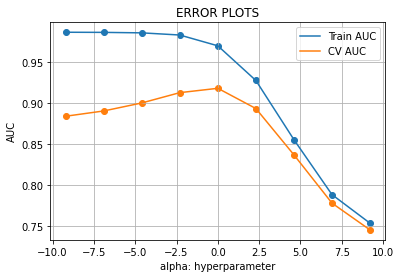

In [25]:
train_auc = []
cv_auc = []
alpha = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
for param in alpha:
    naive = MultinomialNB(alpha=param)
    naive.fit(X_train_bow,y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    y_train_pred =  naive.predict_proba(X_train_tfidf)[:,1]
    y_test_pred =  naive.predict_proba(X_test_tfidf)[:,1]
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_test, y_test_pred))
#plotting
plt.grid(True)
plt.plot(np.log(alpha), train_auc, label='Train AUC')
plt.plot(np.log(alpha), cv_auc, label='CV AUC')
plt.scatter(np.log(alpha), train_auc)
plt.scatter(np.log(alpha), cv_auc)
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

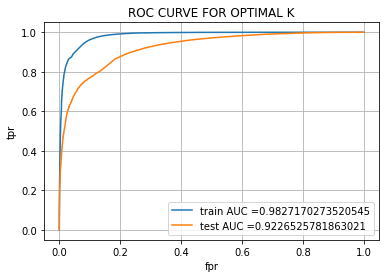

Area under train roc 0.9827170273520545
Area under test roc 0.9226525781863021


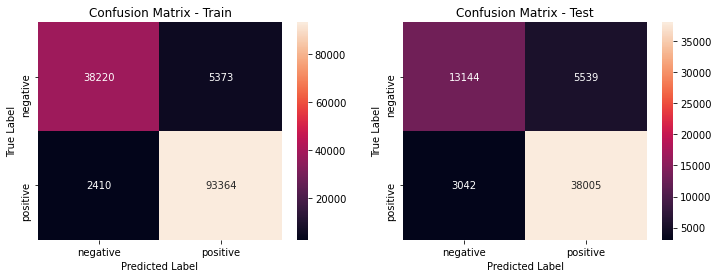


-----classification report on train data on TFIDF Features-----

              precision    recall  f1-score   support

           0       0.94      0.88      0.91     43593
           1       0.95      0.97      0.96     95774

    accuracy                           0.94    139367
   macro avg       0.94      0.93      0.93    139367
weighted avg       0.94      0.94      0.94    139367


-----classification report on validation data on TFIDF Features-----

              precision    recall  f1-score   support

           0       0.81      0.70      0.75     18683
           1       0.87      0.93      0.90     41047

    accuracy                           0.86     59730
   macro avg       0.84      0.81      0.83     59730
weighted avg       0.85      0.86      0.85     59730



In [35]:
from sklearn.metrics import roc_curve, auc, classification_report, accuracy_score
optimal_alpha = 0.1
naive_opt = MultinomialNB(alpha=optimal_alpha)
naive_opt = naive_opt.fit(X_train_tfidf,y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, naive_opt.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, naive_opt.predict_proba(X_test_tfidf)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))

plot_confusion_matrixes(naive_opt,X_train_tfidf,y_train,X_test_tfidf,y_test)

#classification report on train data
print('\n-----classification report on train data on TFIDF Features-----\n')
print(classification_report(y_train, naive_opt.predict(X_train_tfidf)))

#classification report on validation data
print('\n-----classification report on validation data on TFIDF Features-----\n')
print(classification_report(y_test, naive_opt.predict(X_test_tfidf)))


# **Feature importance**


In [36]:
data_l = naive_opt.coef_.reshape(-1,1)
features = tfidf_features
datafr_l = pd.DataFrame(data_l,columns=['coef'],index=features)
#Top 10 negative features
negative = datafr_l.sort_values(by='coef').head(10)
#Top 10 positive features
positive = datafr_l.sort_values(by='coef',ascending=False).head(10)
print('Top 10 negative features are: \n {}'.format(negative))
print('--'*50)
print('Top 10 positive features are: \n {}'.format(positive))

Top 10 negative features are: 
                   coef
قاطع_أوريدو -14.582535
lestebdedd  -14.582535
لتوة        -14.582535
lesvde      -14.582535
thimna      -14.582535
leswisra    -14.582535
lesyadek    -14.582535
lesyadha    -14.582535
lesyedhom   -14.582535
lesyesa     -14.582535
----------------------------------------------------------------------------------------------------
Top 10 positive features are: 
                  coef
ربي         -4.799088
rabi        -4.904950
bravo       -4.919595
ya          -5.178744
الله        -5.279204
et          -5.543052
nan         -5.593614
très        -5.621999
application -5.628708
slim        -5.646318


# **Observations and Conclusions**

* We tried out multinomial naive bayes here with bow and tfidf features we tried earlier.
* Even after hyperparamter tuning both models are slightly overfitting.
* Tfidf features model performed slightly better.
* We also able to find out most important features contributing to each model
* Naive bayes can be considered as a baseline model for our problem



In [40]:
from prettytable import PrettyTable
    
z = PrettyTable()
z.field_names = ["Vector","Algorithm","Hyperparameter-alpha", "Train AUC", "Test AUC","Train accuracy", "Test accuracy"]
z.add_row(["bow","naive-bayes",0.1,0.9774466824302217, 0.9104516992132788,0.94,0.85])
z.add_row(["tfidf","naive-bayes",0.1,0.9827170273520545,0.9226525781863021,0.94,0.86])
print(z)

+--------+-------------+----------------------+--------------------+--------------------+----------------+---------------+
| Vector |  Algorithm  | Hyperparameter-alpha |     Train AUC      |      Test AUC      | Train accuracy | Test accuracy |
+--------+-------------+----------------------+--------------------+--------------------+----------------+---------------+
|  bow   | naive-bayes |         0.1          | 0.9774466824302217 | 0.9104516992132788 |      0.94      |      0.85     |
| tfidf  | naive-bayes |         0.1          | 0.9827170273520545 | 0.9226525781863021 |      0.94      |      0.86     |
+--------+-------------+----------------------+--------------------+--------------------+----------------+---------------+
